In [1]:
import numpy as np
import pandas as pd
import yaml
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List
from pathlib import Path

from src.features.denoise_ndvi_signal import denoise_signal, downsample_time_series, moving_std_filter, holt_winters_filter
from src import paths

In [2]:
params_path = paths.config_dir("params.yaml")
metrics_dir: Path = paths.reports_dir("metrics")
fault_detection_dir: Path = paths.data_processed_dir("fault_detection")

In [3]:
with open(params_path, "r") as file:
    params = yaml.safe_load(file)

selected_band: str = params["selected_band"]
N_values: List[int] = params["N_values"]
k_values: List[float] = params["k_values"]
th_values: List[float] = params["voting_thresholds"]

selected_score: str = params["parameter_study_max_metric_prefix"]
stable_event_types: List[str] = params["stable_event_types"]
change_event_types: List[str] = params["change_event_types"]
weeks_after_change_offset: int = params["weeks_after_change_offset"]

optimal_model_params_filename = "_".join(
    ["max",
     selected_score,
     "params",
     selected_band])
optimal_model_params_filename += ".json"
optimal_model_params_path = metrics_dir / optimal_model_params_filename

with open(optimal_model_params_path, "r") as file:
    optimal_model_params = json.load(file)

th = optimal_model_params["th"]
k = optimal_model_params["k"]
N = optimal_model_params["N"]

In [4]:
fault_detection_metadata_filename = "_".join(
    ["fault_detection_metadata", selected_band])
fault_detection_metadata_filename += ".csv"

fault_detection_metadata_path = fault_detection_dir / \
    fault_detection_metadata_filename

pixel_true_values_df = pd.read_csv(
    fault_detection_metadata_path, index_col=["ID", "IDpix"])

pixel_true_values_df = pixel_true_values_df[pixel_true_values_df["vegetation_type"] == "native"]

pixel_true_values_df = pixel_true_values_df[[
    "label", "change_start", "last_non_change_date"]]
pixel_true_values_df["change_start"] = pd.to_datetime(
    pixel_true_values_df["change_start"])
pixel_true_values_df["last_non_change_date"] = pd.to_datetime(
    pixel_true_values_df["last_non_change_date"])

In [5]:
fault_detection_signal_filename = "_".join(
    ["fault_detection_signal", selected_band])
fault_detection_signal_filename += ".csv"

fault_detection_signal_path = fault_detection_dir / \
    fault_detection_signal_filename

pixel_signal_df = pd.read_csv(
    fault_detection_signal_path, index_col=["ID", "IDpix"])

pixel_signal_df.columns = pd.to_datetime(pixel_signal_df.columns)

In [6]:
filename = f"predictions_N={N}_k={k}_{selected_band}.csv"
pix_pred_path = paths.data_processed_dir("pixel_predictions", filename)
pix_pred_values_df = pd.read_csv(pix_pred_path, index_col=["ID", "IDpix"])
pix_pred_values_df["event_date"] = pd.to_datetime(
    pix_pred_values_df["event_date"])
pix_pred_values_df = pix_pred_values_df.loc[pixel_true_values_df.index]

In [7]:
filename = f"predictions_N={N}_k={k}_th={th}_{selected_band}.csv"
poly_pred_path = paths.data_processed_dir("poly_predictions", filename)
poly_pred_values_df = pd.read_csv(poly_pred_path, index_col="ID")
# poly_pred_values_df["event_date"] = pd.to_datetime(poly_pred_values_df["event_date"])

In [8]:
poly_true_values_df = pixel_true_values_df.groupby(
    "ID")[["change_start", "label", "last_non_change_date"]].min()

In [9]:
poly_pred_values_df = poly_pred_values_df.loc[poly_true_values_df.index]

In [10]:
poly_true_values_df

,change_start,label,last_non_change_date
ID,,,
6,1800-01-01,0,2022-05-01
7,1800-01-01,0,2021-02-22
8,1800-01-01,0,2020-10-07
10,1800-01-01,0,2021-08-01
11,1800-01-01,0,2021-02-02
...,...,...,...
401,2018-03-31,1,2016-07-26
402,2018-03-23,1,2016-09-17
403,2018-11-17,1,2017-11-20


In [11]:
y_pred = poly_pred_values_df["prediction"]

In [12]:
y_true = poly_true_values_df["label"]

In [128]:
selected_indices = y_true[
    (y_true != y_pred) &
    (y_true == 0)
].index

In [129]:
selected_pred = pix_pred_values_df.loc[selected_indices]

In [130]:
selected_signal = pixel_signal_df.loc[selected_indices]

In [131]:
selected_indices

Index([ 42, 240, 246, 247, 248, 249, 250, 251, 252, 254, 255, 257, 258, 259,
       264, 265, 267, 272, 274, 275, 276, 277, 281, 286, 287, 289, 292, 293,
       294, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 326],
      dtype='int64', name='ID')

In [132]:
sel_index = 315
median_date = selected_pred.loc[sel_index]["event_date"].median()
sel_pix_index = (selected_pred.loc[sel_index]
                 ["event_date"] - median_date).abs().idxmin()

In [133]:
selected_pred.loc[sel_index]

,prediction,event_date
IDpix,,
6356,1.0,2022-03-06
6357,1.0,2022-03-13
6358,1.0,2022-08-21
6359,1.0,2022-01-23
6360,1.0,2022-03-13
6361,1.0,2022-07-10
6362,1.0,2022-07-10
6363,1.0,2022-03-13


In [134]:
selected_pred.loc[sel_index, sel_pix_index]

prediction                    1.0
event_date    2022-03-13 00:00:00
Name: (315, 6357), dtype: object

In [135]:
pixel_true_values_df.loc[sel_index, sel_pix_index]

label                                     0
change_start            1800-01-01 00:00:00
last_non_change_date    2022-10-19 00:00:00
Name: (315, 6357), dtype: object

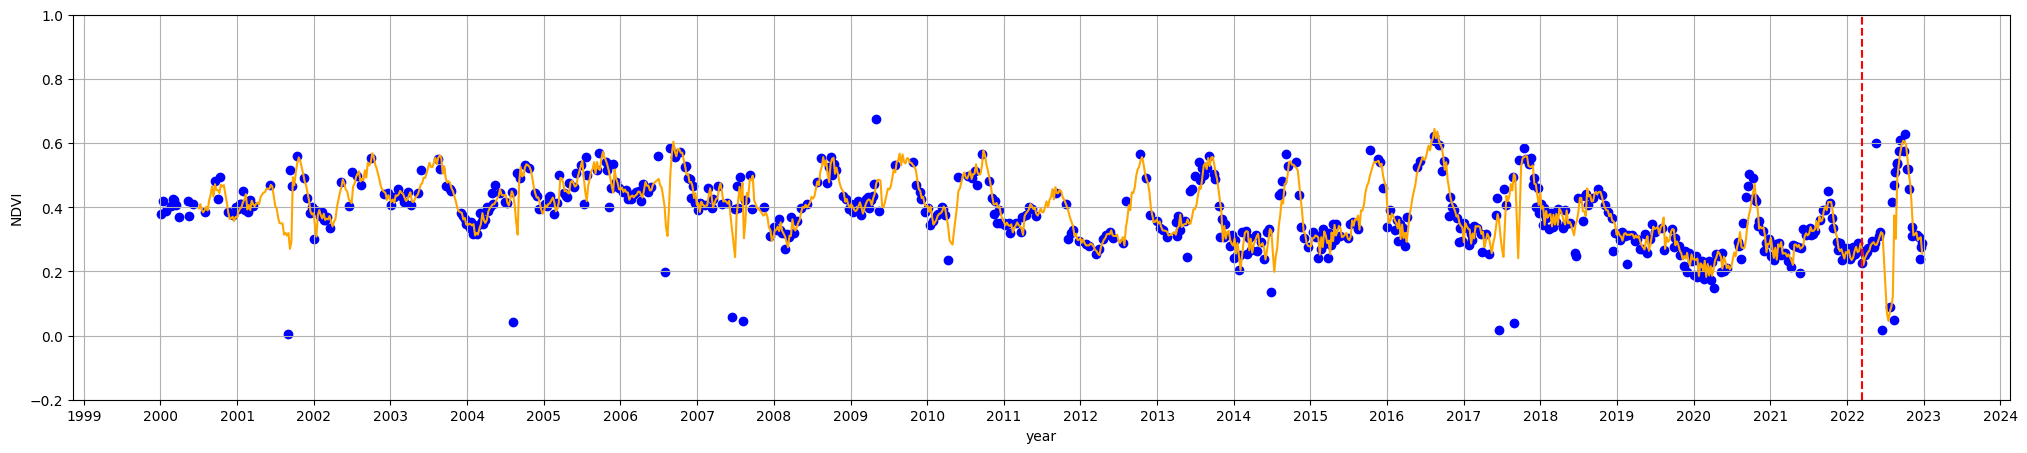

In [136]:
date_offset = pd.DateOffset(
    weeks=weeks_after_change_offset
)

sample_poly = (sel_index, sel_pix_index)

detected_event_date = selected_pred["event_date"].loc[sample_poly]
actual_event_date = pixel_true_values_df["change_start"].loc[sample_poly]
last_stable_date = pixel_true_values_df["last_non_change_date"].loc[sample_poly]

raw_signal = selected_signal.loc[sample_poly]
denoised_signal = denoise_signal(
    raw_signal, [downsample_time_series, moving_std_filter, holt_winters_filter])

_, ax = plt.subplots()


# ax.plot(denoised_signal[last_stable_date - pd.DateOffset(years=5): actual_event_date + date_offset],
#         color="orange")
# ax.scatter(raw_signal[last_stable_date - pd.DateOffset(years=5): actual_event_date + date_offset].index,
#            raw_signal[last_stable_date -
#                       pd.DateOffset(years=5): actual_event_date + date_offset],
#            color="b")

ax.plot(denoised_signal,
        color="orange")
ax.scatter(raw_signal.index,
            raw_signal,
            color="b")


ax.axvline(x=detected_event_date, color='r', linestyle='--')
# ax.axvline(x=actual_event_date, color='g', linestyle='--')
# ax.axvline(x=last_stable_date, color='g', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator())

plt.gcf().set_size_inches(*(25, 5))
plt.grid()
plt.ylim(-.2, 1)
plt.ylabel("NDVI")
plt.xlabel("year")
plt.show()

In [137]:
print("Detected event date: ", detected_event_date)
print("Tagged event date: ", actual_event_date)
print("Last stable date: ", last_stable_date)

Detected event date:  2022-03-13 00:00:00
Tagged event date:  1800-01-01 00:00:00
Last stable date:  2022-10-19 00:00:00


#### Polígonos buenos para plottear (TP)
- 397

#### Polígonos buenos para plotter (FP)
- 315